In [0]:
import os
import keras
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils import np_utils
from keras.optimizers import adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import img_to_array
from keras.metrics import categorical_crossentropy
#from sklearn.cross_validation import train_test_split
from keras.layers import Dense,Dropout,Activation,Flatten,Conv2D
from keras.layers.convolutional import Convolution2D,MaxPooling2D

from keras import backend as K
K.set_image_dim_ordering('th')


# Build VGG16 model-Sequential

VGG16 works with activation="softmax" which does not works here.

In [0]:
#vgg16_model=keras.applications.vgg16.VGG16()
vgg16_model = keras.applications.VGG16(weights='imagenet', input_shape = (3,224,224))

In [0]:
vgg16_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

vgg16 is a model not a sequential model. It needs to be transformed to a sequential model.
Sequential model create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

In [0]:
type(vgg16_model)


keras.engine.training.Model

In [0]:
model=Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    model.trainable=False
    

Remove the last layer of 1000 categories and add the current selection

In [0]:
model.add(Dense(units=2))
model.add(Activation(tf.nn.softmax))

In [0]:
model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

# Prediction

In [0]:
from keras.preprocessing.image import load_img
# load an image from file
image_path='dog.6.jpg'
image = load_img(image_path, target_size=(224, 224))

In [0]:
np.shape(image)

(224, 224, 3)

In [0]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [0]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [0]:
from keras.applications.vgg16 import decode_predictions
# predict the probability across all output classes
yhat = model.predict(image)
yhat

array([[0.79856414, 0.2014359 ]], dtype=float32)

# Build VGG16 model-Non Sequential

In [0]:
#keras.applications.vgg16.VGG16()
vgg_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (3,224,224))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

In [0]:
# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Stacking a new simple convolutional network on top of it    
#x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation=tf.nn.softmax)(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:-3]:
    layer.trainable = False

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
yhat = custom_model.predict(image)
yhat

array([[0.81092805, 0.18907192]], dtype=float32)

# Build VGG16 model-Freezing layes

In [0]:
from keras.preprocessing.image import ImageDataGenerator

pp='/Users/atousa/Desktop/McMaster/BDA-102/Neural_network/data/'
train_path=pp+'cat-and-dog/training_set/'
valid_path=pp+'cat-and-dog/valid_set/'
test_path=pp+'cat-and-dog/test_set/'

img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=30)
valid_batches=datagen.flow_from_directory(
               valid_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=10)
test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=10)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [0]:
#keras.applications.vgg16.VGG16()

vgg_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (3,224,224))

for layer in vgg_model.layers[:5]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer, layer.trainable)
    

<keras.engine.topology.InputLayer object at 0x1c4142a7f0> False
<keras.layers.convolutional.Conv2D object at 0x1c282a44a8> False
<keras.layers.convolutional.Conv2D object at 0x1c4142a908> False
<keras.layers.pooling.MaxPooling2D object at 0x1c41427d68> False
<keras.layers.convolutional.Conv2D object at 0x1c415cf7b8> False
<keras.layers.convolutional.Conv2D object at 0x1c415cf320> True
<keras.layers.pooling.MaxPooling2D object at 0x1c5283c940> True
<keras.layers.convolutional.Conv2D object at 0x1c52880320> True
<keras.layers.convolutional.Conv2D object at 0x1c52899e48> True
<keras.layers.convolutional.Conv2D object at 0x1c52990978> True
<keras.layers.pooling.MaxPooling2D object at 0x1c529c1588> True
<keras.layers.convolutional.Conv2D object at 0x1c529f0668> True
<keras.layers.convolutional.Conv2D object at 0x1c529f0fd0> True
<keras.layers.convolutional.Conv2D object at 0x1c52a36c88> True
<keras.layers.pooling.MaxPooling2D object at 0x1c52a80828> True
<keras.layers.convolutional.Conv2D o

In [0]:
#Adding custom Layers 
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

model_final = Model(input = vgg_model.input, output = predictions)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [0]:
# creating the final model 

# Do not forget to compile it
model_final.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])


model_final.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                steps_per_epoch=4,#train_batches.samples/train_batches.batch_size,,
                validation_steps=4,#valid_batches.samples/valid_batches.batch_size,,
                verbose=2,
                #shuffle=False, 
                epochs=3)

Epoch 1/3
174s - loss: 8.4620 - acc: 0.4750 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 2/3
172s - loss: 9.6709 - acc: 0.4000 - val_loss: 11.0812 - val_acc: 0.3125
Epoch 3/3
161s - loss: 5.6413 - acc: 0.6500 - val_loss: 6.0443 - val_acc: 0.6250


# Data Augmentation

Data Augmentation occures when creating new data with modification.
Filpp, Rotate, Zoom,Color change,Cropping

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc,ndimage
import keras
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator

In [0]:
gen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.15,
                       zoom_range=0.1,channel_shift_range=10,
                       horizontal_flip=True)

In [0]:
import cv2
image_path='/Users/atousa/Desktop/McMaster/BDA-102/Neural_network/data/cat-and-dog/dog.6.jpg'

In [0]:
image=cv2.imread(image_path)

In [0]:
np.shape(image)

(488, 499, 3)

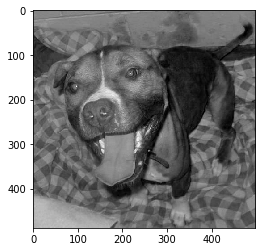

In [0]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,0], cmap='gray')
plt.show()

generate batches of image

In [0]:
np.shape(image)

(488, 499, 3)

In [0]:
image_batch = image.reshape((1,) + image.shape)

In [0]:
np.shape(image_batch)

(1, 488, 499, 3)

Get 10 sample of the batches

In [0]:
aug_iter=gen.flow(image_batch, batch_size=2)
aug_images=[next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [0]:
np.shape(aug_images)

(10, 488, 499, 3)

In [0]:
img = aug_images[0]

In [0]:
np.shape(img)

(488, 499, 3)

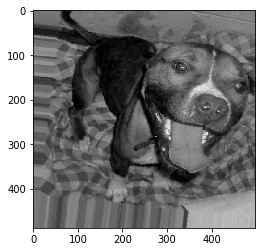

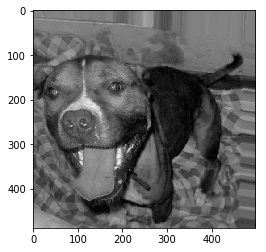

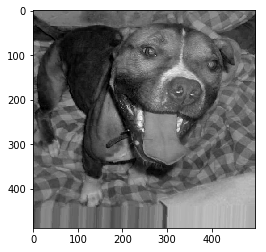

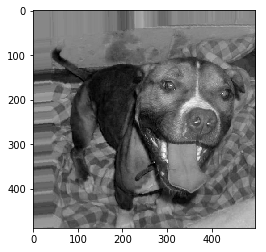

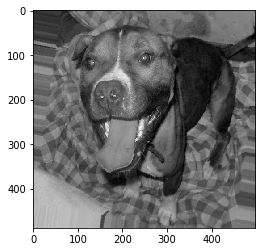

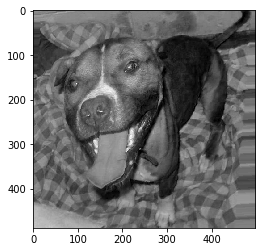

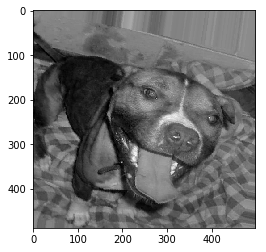

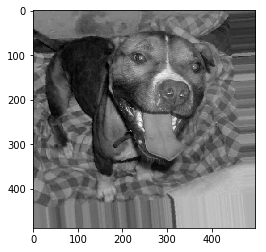

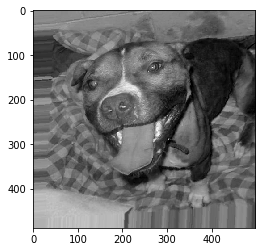

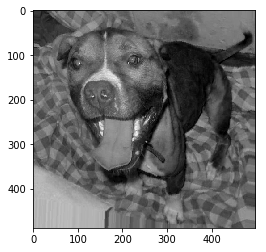

In [0]:
for i in range(0,10):
    img = aug_images[i]
    plt.imshow(img[:,:,0].astype('uint8'), cmap='gray')
    plt.show()    